In [18]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [20]:
df_raw = pd.read_csv('data/ct_ev_registrations_public.csv')
# df_raw = df_raw[(df_raw.Technology == 'BEV')]
df_raw.head()

,DMV ID,DMV Snapshot (Date),ZIP Code,Registration Valid Date,Registration Expiration Date,VIN Prefix,VIN Model Year,Make,Model,Model Year
0,2,DMV Direct (1/4/2018),6457,1/4/2018,12/31/2018,1G1FX6S0,H,Chevrolet,Bolt EV,2017
1,2,DMV Direct (1/4/2018),6278,1/4/2018,12/31/2018,1G1FX6S0,H,Chevrolet,Bolt EV,2017
2,2,DMV Direct (1/4/2018),6880,1/4/2018,12/31/2018,1G1FX6S0,H,Chevrolet,Bolt EV,2017
3,2,DMV Direct (1/4/2018),6902,1/4/2018,12/31/2018,1G1FX6S0,H,Chevrolet,Bolt EV,2017
4,2,DMV Direct (1/4/2018),6013,1/4/2018,12/31/2018,1G1FX6S0,H,Chevrolet,Bolt EV,2017


In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2011-11-19,1.0
2012-07-12,1.0
2012-07-24,1.0
2012-08-09,1.0
2012-08-11,1.0
...,...
2016-11-11,6.0
2016-11-12,7.0
2016-11-13,2.0


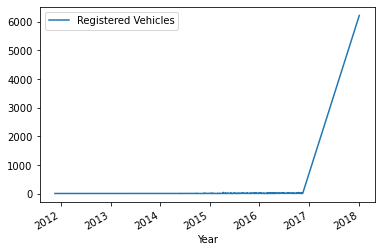

In [22]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df

In [23]:
df['Registered Vehicles'].sum()

11439.0

## **RESAMPLING

            Registered Vehicles
Year                           
2011-11-30                  1.0
2011-12-31                  1.0
2012-01-31                  1.0
2012-02-29                  1.0
2012-03-31                  1.0


<AxesSubplot:xlabel='Year'>

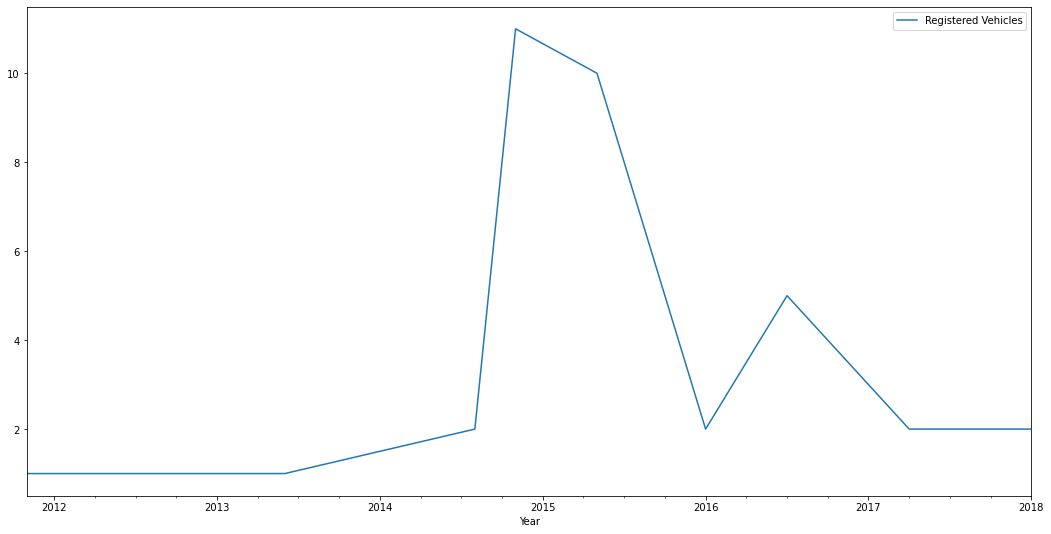

In [15]:
# Interpolate - Backfill 
df = df.resample('M').interpolate(method = 'linear')
df = df.bfill()
print(df.head())
df.plot()

In [6]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

In [7]:
# # #Frontfill 
# df = df.resample('M').ffill()
# df.plot()

## Testing 

In [16]:
adtest = adfuller(df)
display(adtest)

(-2.4778186863947584,
 0.12096497479733498,
 4,
 70,
 {'1%': -3.5274258688046647,
  '5%': -2.903810816326531,
  '10%': -2.5893204081632653},
 99.37785352090945)

## Modeling

In [9]:
# Splitting Training and Testing data; using after 2019 as test

train = df['2011-11-19':'2020-12-31']
test = df['2020-12-31':]
combined = df

test

,Registered Vehicles
Year,


In [10]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1607.239, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1345.705, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1475.865, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1285.200, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1247.848, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1241.779, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=1241.334, Time=0.07 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=1243.038, Time=0.10 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=1228.375, Time=0.24 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=1227.353, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1235.337, Time=0.15 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=1228.535, Time=0.32 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1237.631, Time=0.23 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : 

### The best model is :  ARIMA (1,00) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7495      0.020     37.663      0.000       0.710       0.788
sigma2         3.8270      0.120     31.975      0.000       3.592       4.062


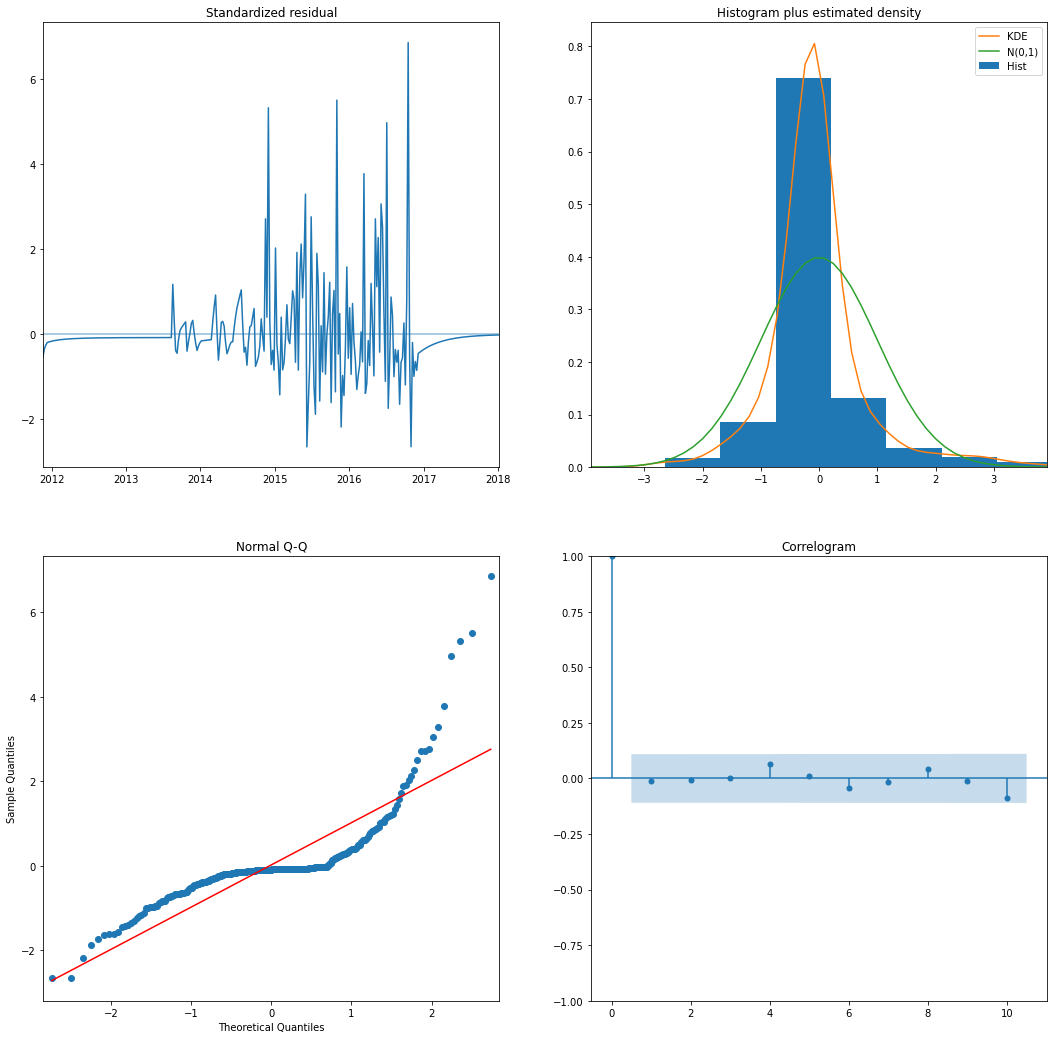

In [11]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(1,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [12]:
pred = output.get_prediction(start=pd.to_datetime('2020-12-31'), end=pd.to_datetime('2021-07-19'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2021-01-03,-5.791722,5.791722
2021-01-10,-5.791722,5.791722
2021-01-17,-5.791722,5.791722
2021-01-24,-5.791722,5.791722
2021-01-31,-5.791722,5.791722
2021-02-07,-5.791722,5.791722
2021-02-14,-5.791722,5.791722
2021-02-21,-5.791722,5.791722
2021-02-28,-5.791722,5.791722
2021-03-07,-5.791722,5.791722


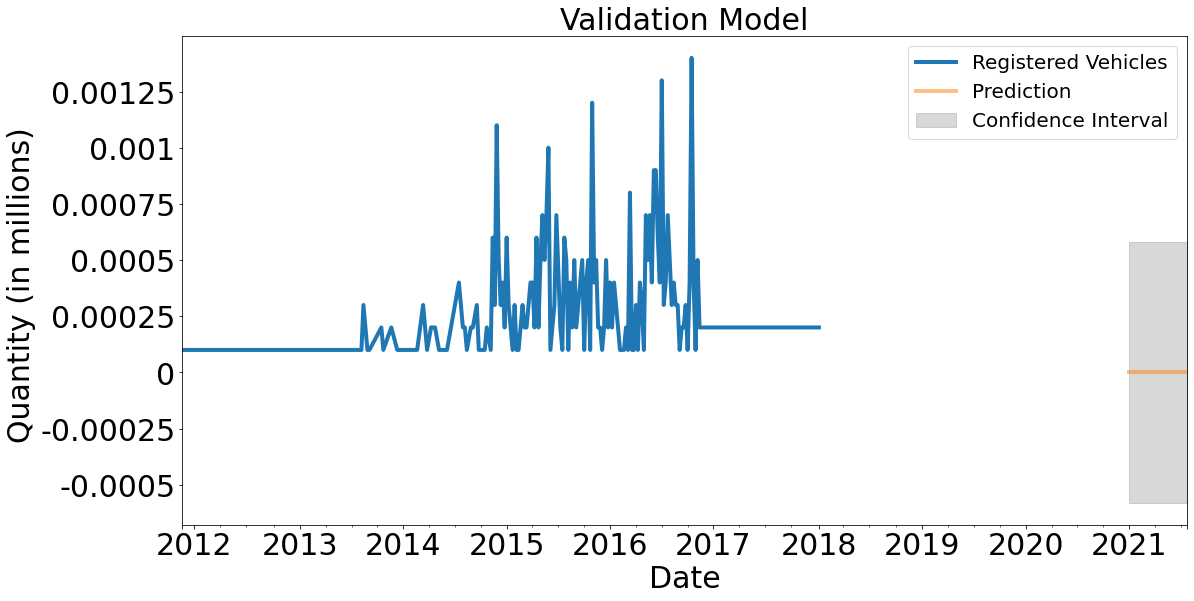

In [13]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in millions) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e4
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()